# Step 1: convert the JSON file into csv

In [1]:
import json
import csv

conversation_name = "consolidated_telemetry"
inputFileName = conversation_name + ".json"
outcsvFileName = conversation_name + "telemetry_output.csv"
# Load the JSON file into a Python Dictionary
with open(inputFileName, 'r') as file:
    data = json.load(file)

# 'data' is now a Python dictionary
#w_file.write(data)

# Access dictionary data
# there are four parts of data in each conversation - 

# Part 1 - Meta data Info
# the consolidated data file includes "consolidation_timestamp", "total_conversations", "total_conversations" and "file_count"



print("*** Part 1 - MetaData Info*** ")
print("consolidation_timestamp: ",  data["metadata"]["consolidation_timestamp"])
print("total_conversations: " ,  data["metadata"]["total_conversations"])
print("total_conversations: ", data["metadata"]["source_directory"])
print("file_count: ", data["metadata"]["file_count"])

# Part 2 - Conversations Info
# Save the conversations Info into a csv file
# Each conversation includes 4 parts - conversation_info, prompts, responses and telemetry


# "telemetry"
# Each telemetry includes 5 attributes -- type, agent_id, timestamp, metadata, details
# metadata - the values in "details" is the first attributes
# 'thought' => context {'prompt' and 'conversation_id'} ** process user's prompt
# 'action_type' =>  {'action_type', 'action_input' (prompt), 'action_output' (none)} 
# 'tool_name' => {'tool_name', 'tool_input' (prompt), 'tool_output' (response)}
# details - 'thought', 'action_type', 'tool_name' 
# create consolidated csv file - source_file, conversation_id, agent_id, conversation_timestamp, type, timestamp, thought, action_type, tool_name, prompt, response
with open(outcsvFileName, 'w') as csv_file:
    fieldNames = ["source_file","conversation_id", "agent_id","conversation_timestamp", "type", "timestamp", "thought", "action_type", "tool_name", "prompt", "response"]
    writer = csv.DictWriter(csv_file, fieldnames=fieldNames)
    writer.writeheader()

    conversations = data["conversations"]
    for conversation in conversations:
        source_file = conversation["source_file"]
        conversation_id = conversation["conversation_id"]
        agent_id = conversation["agent_id"]
        conversation_timestamp = conversation["timestamp"]
        prompts = conversation["prompts"]
        responses = conversation["responses"]
        
        telemetrys = conversation["telemetry"]
        for telemetry in telemetrys:
            if telemetry["type"] == "thinking":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": telemetry["details"]["thought"], "action_type": "none", "tool_name": "none", "prompt": telemetry["metadata"]["context"]["prompt"], "response": "none"})
            elif telemetry["type"] == "action":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": "none", "action_type": telemetry["details"]["action_type"], "tool_name": "none", "prompt": telemetry["metadata"]["action_input"], "response": telemetry["metadata"]["action_output"]})
            elif telemetry["type"] == "tool_use":
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": "none", "action_type": "none", "tool_name": telemetry["details"]["tool_name"], "prompt": telemetry["metadata"]["tool_input"], "response": telemetry["metadata"]["tool_output"]})
            else:
                writer.writerow({"source_file": source_file, "conversation_id": conversation_id, "agent_id": agent_id,"conversation_timestamp": conversation_timestamp, "type": telemetry["type"], "timestamp": telemetry["timestamp"], "thought": telemetry["details"], "action_type": telemetry["details"], "tool_name": telemetry["details"], "prompt": "none", "response": "none"})


print("********** program run correctly!!******")
print("read file from ", inputFileName)
print("consolidated data written into csv file, ", outcsvFileName )

*** Part 1 - MetaData Info*** 
consolidation_timestamp:  2025-06-19T14:06:29.656521
total_conversations:  369
total_conversations:  telemetry
file_count:  369
********** program run correctly!!******
read file from  consolidated_telemetry.json
consolidated data written into csv file,  consolidated_telemetrytelemetry_output.csv


# Step 2-1: load the csv file into a table and add necessary columns

In [2]:
# These lines import the NumPy and Datascience modules.
from datascience import *
import numpy as np

# These lines do some fancy plotting magic.
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
consolidated = Table.read_table('consolidated_telemetrytelemetry_output.csv')
consolidated.show(20)

source_file,conversation_id,agent_id,conversation_timestamp,type,timestamp,thought,action_type,tool_name,prompt,response
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:08.465146,"Processing user prompt: Hello, how are you today?",none,none,"Hello, how are you today?",none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:08.466644,none,openai_chat,none,"Hello, how are you today?",nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:09.058300,none,none,openai_chat,"Hello, how are you today?","Hello! I'm just a computer program, so I don't have feel ..."
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:10.064109,Processing user prompt: What's the weather like?,none,none,What's the weather like?,none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:10.065628,none,openai_chat,none,What's the weather like?,nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:11.187935,none,none,openai_chat,What's the weather like?,"I'm sorry, I don't have real-time information on the wea ..."
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:12.193256,Processing user prompt: Can you tell me a joke?,none,none,Can you tell me a joke?,none
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:12.194746,none,openai_chat,none,Can you tell me a joke?,nan
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:13.302820,none,none,openai_chat,Can you tell me a joke?,Sure! Here's a joke for you: Why couldn't the bicycle st ...
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:14.305918,Processing user prompt: What is artificial intelligence?,none,none,What is artificial intelligence?,none


In [4]:
from datetime import datetime

duration = consolidated.apply(datetime.fromisoformat, "timestamp") - consolidated.apply(datetime.fromisoformat, "conversation_timestamp")

# Duration in seconds
duration = [x.total_seconds() for x in duration] 

In [5]:
print(max(duration), min(duration))

20.641844 1.5e-05


In [6]:
consolidated = consolidated.with_columns("duration", duration)
consolidated.show(20)

source_file,conversation_id,agent_id,conversation_timestamp,type,timestamp,thought,action_type,tool_name,prompt,response,duration
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:08.465146,"Processing user prompt: Hello, how are you today?",none,none,"Hello, how are you today?",none,3.1e-05
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:08.466644,none,openai_chat,none,"Hello, how are you today?",nan,0.001529
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:09.058300,none,none,openai_chat,"Hello, how are you today?","Hello! I'm just a computer program, so I don't have feel ...",0.593185
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:10.064109,Processing user prompt: What's the weather like?,none,none,What's the weather like?,none,1.59899
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:10.065628,none,openai_chat,none,What's the weather like?,nan,1.60051
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:11.187935,none,none,openai_chat,What's the weather like?,"I'm sorry, I don't have real-time information on the wea ...",2.72282
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:12.193256,Processing user prompt: Can you tell me a joke?,none,none,Can you tell me a joke?,none,3.72814
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,action,2025-06-19T19:28:12.194746,none,openai_chat,none,Can you tell me a joke?,nan,3.72963
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,tool_use,2025-06-19T19:28:13.302820,none,none,openai_chat,Can you tell me a joke?,Sure! Here's a joke for you: Why couldn't the bicycle st ...,4.8377
conversation_conv_1750361288_20250619_122824.json,conv_1750361288,custom-agent,2025-06-19T19:28:08.465115,thinking,2025-06-19T19:28:14.305918,Processing user prompt: What is artificial intelligence?,none,none,What is artificial intelligence?,none,5.8408


In [7]:
durationInfo = consolidated.group("type", np.average).select("type", "duration average")
duration_max = consolidated.group("type", max).column("duration max")
duration_min = consolidated.group("type", min).column("duration min")
durationInfo = durationInfo.with_columns("duration min", duration_min, "duration max", duration_max)
durationInfo

type,duration average,duration min,duration max
action,5.68027,0.000102,19.4512
thinking,5.67979,1.5e-05,19.4506
tool_use,6.94959,0.262408,20.6418


In [13]:
duration_table = Table().with_columns(
    'action', consolidated.where('type', "action").column("duration"),
    'thinking', consolidated.where('type', "thinking").column("duration"),
    'tool_use', consolidated.where('type', "tool_use").column("duration")
)
duration_table.show(20)

action,thinking,tool_use
0.001529,3.1e-05,0.593185
1.60051,1.59899,2.72282
3.72963,3.72814,4.8377
5.84097,5.8408,7.62618
8.62743,8.62712,11.719
12.725,12.7248,14.9645
0.001555,2.3e-05,1.62365
2.62969,2.62895,2.98517
3.98745,3.98724,5.09231
6.09774,6.09759,6.88855


In [9]:
update_duration_table = Table().with_columns(
    'thinking', duration_table.column("thinking"),
    'action', duration_table.column("action") - duration_table.column("thinking"),
    'tool_use', duration_table.column("tool_use")- duration_table.column("action")
)
update_duration_table.show(100)

thinking,action,tool_use
3.1e-05,0.001498,0.591656
1.59899,0.001519,1.12231
3.72814,0.00149,1.10807
5.8408,0.000168,1.78521
8.62712,0.00031,3.09158
12.7248,0.000264,2.23942
2.3e-05,0.001532,1.6221
2.62895,0.000749,0.355479
3.98724,0.000212,1.10485
6.09759,0.000144,0.790816


In [10]:
def print_statistics(str, tbl):
    x = tbl.column(str)
    print("**", str, "**", " duration time")
    print("Average:", np.average(x))
    print("Min:", min(x))
    print("Max:", max(x))
    
print_statistics("thinking", update_duration_table)
print_statistics("action", update_duration_table)
print_statistics("tool_use", update_duration_table)

** thinking **  duration time
Average: 5.67978847561
Min: 1.5e-05
Max: 19.450594
** action **  duration time
Average: 0.000476697831978
Min: 8.7e-05
Max: 0.030542
** tool_use **  duration time
Average: 1.2693243523
Min: 0.242496
Max: 7.859537


## The histogram

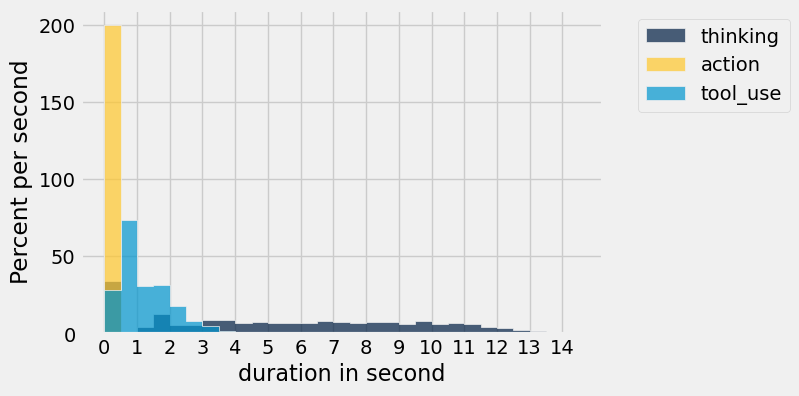

In [11]:
update_duration_table.hist(bins=np.arange(0, 15, 0.5), unit='duration in second')
_ = plots.xlabel('duration in second')
_ = plots.ylabel('Percent per second')
_ = plots.xticks(np.arange(15))

## The line chart

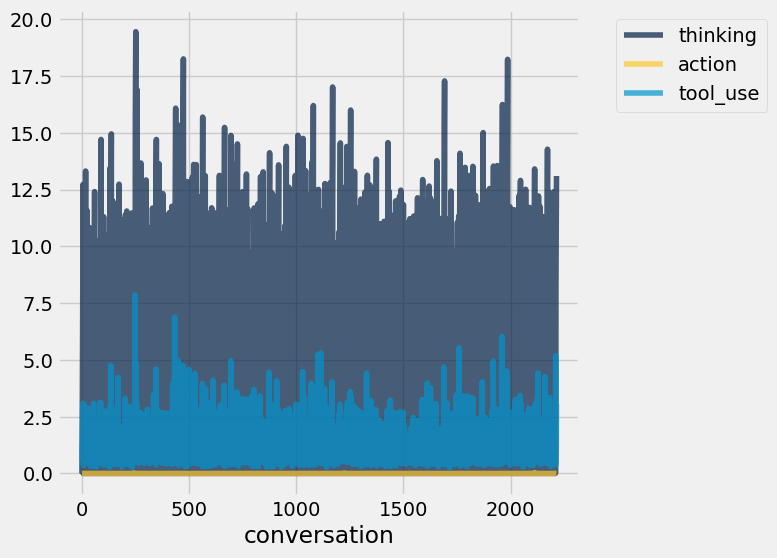

In [15]:
update_duration_table = update_duration_table.with_columns("conversation", np.arange(1, 369*6 + 1))
update_duration_table.plot("conversation")

****The duration for "action" is small, need to see the pattern in another line chart alone.

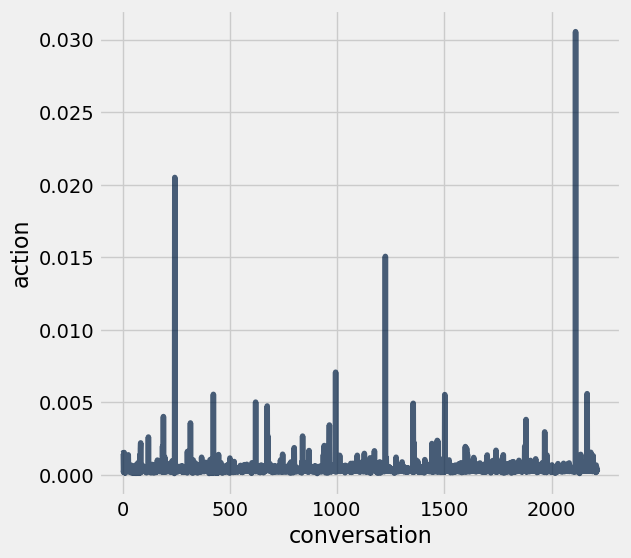

In [16]:
update_duration_table.plot("conversation", "action")

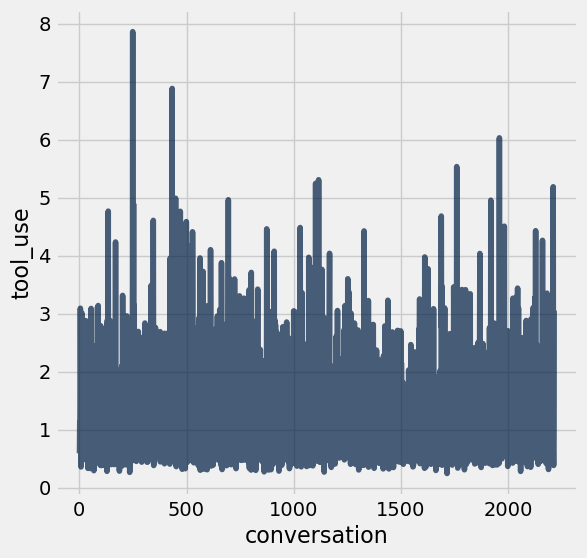

In [17]:
update_duration_table.plot("conversation", "tool_use")

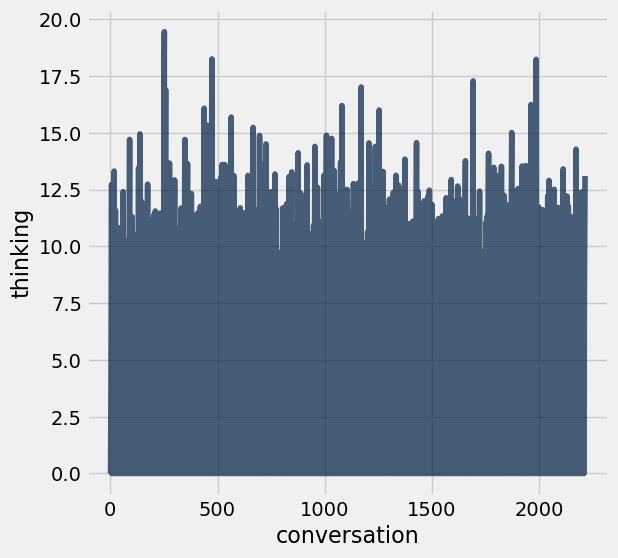

In [18]:
update_duration_table.plot("conversation", "thinking")

# Step 2-2: load the csv file using pandas

In [12]:
import pandas as pd  

consolidated_df = pd.read_csv('consolidated_telemetrytelemetry_output.csv')
print(consolidated_df.shape)
print(consolidated_df.describe())
print(consolidated_df.dtypes)

(6642, 11)
                                              source_file  conversation_id  \
count                                                6642             6642   
unique                                                369              369   
top     conversation_conv_1750361288_20250619_122824.json  conv_1750361288   
freq                                                   18               18   

            agent_id      conversation_timestamp      type  \
count           6642                        6642      6642   
unique           369                         369         3   
top     custom-agent  2025-06-19T19:28:08.465115  thinking   
freq              18                          18      2214   

                         timestamp thought action_type tool_name  \
count                         6642    6642        6642      6642   
unique                        6642      26           2         2   
top     2025-06-19T19:28:08.465146    none        none      none   
freq           